# Prepare Denmark data for machine learning model
For machine learning, data is typically expected to have a certain format. For example, the UNet and ST-UNet models take images that are 256 by 256 pixels. We therefore take the orthographic map of Denmark and split it up into smaller chunks that match this size. 

Another requirement for (supervised) machine learning is that we have some type of ground truth to compare to. Since we want to let our model classify whether there is water or no water for each pixel, the ground truth we desire is a pixel-by-pixel annotation of the presence of water for the orthographic data. We use the `paragraf 3` data for this, which consists of annotations of the protected lakes in Denmark. The annotations consist of polygons, with each point of the polygon being annotated with (x, y) coordinates, i.e. a polygon has coordinates [(x1, y1), (x2, y2), ..., (xn, yn)]. We make a binary mask from these annotated polygons that has the same size as the orthographic image, so we can use the ground truth with our model.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import random
import shapely
from tqdm import tqdm
import geojson
import rasterio.features
import sys
import cv2
from collections import Counter

random.seed(42) # Set a fixed seed for reproducibility

img_width, img_height = 256, 256 # The desired dimensions for UNet

### Load in the TIF file

In [2]:
# Open the tif file containing the orthographic map of Denmark 
path = './ortodata_2014_res_2_crop.tif'
dataset = rasterio.open(path)

# Get some statistics about the data, such as the bounds of the coordinates
bounds = dataset.bounds
left, bottom, right, top = np.array(bounds).astype(int)
transform = dataset.transform
crs = dataset.crs
unit = crs.linear_units

print('Bounds:', left, bottom, right, top)
print('Data shape:', dataset.shape)
print('CRS:', crs)

# Extract the dimensions of a pixel from the transform operation
pixel_width = transform[0]
pixel_height = -transform[4]  # The pixel heigh is negative(?)
pixel_area = pixel_width * pixel_height # Calculate the area of a pixel

print(f"Pixel width: {pixel_width} {unit}s")
print(f"Pixel height: {pixel_height} {unit}s")
print(f"Pixel area: {pixel_area} square {unit}s")

Bounds: 440000 6070000 610000 6340000
Data shape: (135000, 85000)
CRS: EPSG:25832
Pixel width: 2.0 metre
Pixel height: 2.0 metre
Pixel area: 4.0 square metre


### Load in the annotations of the lakes

In [3]:
%%time
# This file contains annotations for different types of nature phenomena (e.g. lakes, forests)
path_to_file = './naturtyper_layer.geojson'

with open(path_to_file, 'r') as f:
    gj = geojson.load(f)
print(len(gj['features']), gj.keys())

# Filter to the annotations of the lakes around Denmark
gj_features = []
for feature in gj['features']:
    if feature['properties']['Natyp_kode'] == 6: # Code for lakes is 6
        gj_features.append(feature)
print(len(gj_features))
gj_features[0]

312325 dict_keys(['type', 'name', 'crs', 'features'])
152920
CPU times: user 1min 2s, sys: 3.95 s, total: 1min 6s
Wall time: 1min 7s


{"geometry": {"coordinates": [[[[501332.248, 6224773.935], [501334.244, 6224779.934], [501334.244, 6224784.933], [501333.246, 6224790.932], [501327.243, 6224789.932], [501317.249, 6224783.933], [501316.243, 6224780.934], [501319.244, 6224774.935], [501324.25, 6224771.936], [501329.247, 6224770.936], [501332.248, 6224773.935]]]], "type": "MultiPolygon"}, "properties": {"Aendr_kode": 0, "Aendrbegr": "Ikke udfyldt", "Besig_dato": null, "Bruger_id": "00000000-0000-0000-0000-000000000000", "CVR_kode": 29189919, "CVR_navn": "Herning kommune", "Gl_sys_ref": null, "Journalnr": null, "Link": null, "Natyp_kode": 6, "Natyp_navn": "Sø", "Objekt_id": "0460cd7c-5353-11e2-af2b-00155d01e765", "Off_kode": 1, "Offentlig": "Synlig for alle", "Oprettet": "2006-12-31T01:00:00", "Oprindelse": "Ikke udfyldt", "Oprindkode": 0, "Sagsbeh": null, "Shape_area": 252.94599999301087, "Shape_length": 0.0, "Status": "Gældende / Vedtaget", "Statuskode": 3, "Systid_fra": "2006-12-31T01:00:00", "Systid_til": null, "Temak

### Create the mask of the full orthographic map of Denmark

In [4]:
# Get dimensions and transform of the original raster
out_shape = (dataset.height, dataset.width)

# Empty list to store the geometries (polygons)
geometries = []

failed, skipped = 0, 0 # Track which annotations could not be converted

# Loop over the annotations
for i, feature in tqdm(enumerate(gj_features)):
    geometry = feature['geometry']
    coords = geometry['coordinates']
    try:
        poly = shapely.geometry.shape(geometry)
        if not poly.is_valid: # Skip invalid shapes
            skipped += 1
            continue
    
        # Get the coordinates of the lake in the form [(x1, y1), (x2, y2), ...]
        coords_xy = np.array(coords).reshape(-1, 2)
        
        # Split x and y coordinates
        x, y = coords_xy[:, 0], coords_xy[:, 1]

        # Ensure we only keep annotations that are within bounds of our map
        x_min, x_max, y_min, y_max = np.min(x), np.max(x), np.min(y), np.max(y)
        if x_min <= bounds.left or x_max >= bounds.right or y_min <= bounds.bottom or y_max >= bounds.top:
            skipped += 1
            continue
        
        # Transform the polygon's coordinates to indices within the orthographic raster
        y_trans, x_trans = rasterio.transform.rowcol(transform, x, y, op = np.round)

        # Convert to a polygon and add to our list of shapes
        poly = shapely.Polygon(zip(x_trans, y_trans))
        
        # Convert to the GeoJSON format for rasterio
        geometries.append((shapely.geometry.mapping(poly), 1))
        
    except Exception as e:
        if failed == 0:
            print(f"Failed to convert annotation {i}: {e}")
        failed += 1
        continue

print('Creating mask...')

# Rasterize all shapes onto a single map
mask = rasterio.features.rasterize(
    geometries, out_shape = out_shape, fill = 0, default_value = 1, dtype = rasterio.uint8   
)

print(f'Failed to convert {failed} annotations')
print(f'Skipped {skipped} annotations')

274it [00:00, 2734.77it/s]

Failed to convert annotation 7: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 2) + inhomogeneous part.


152920it [00:56, 2703.62it/s]


Creating mask...
Failed to convert 3760 annotations
Skipped 59104 annotations


In [5]:
# Prepare folders to store the annotated data in
base_folder = 'denmark_data'
os.makedirs(base_folder, exist_ok = True)
# Create the 'splits' - here we only use the test split as we only evaluate on the Danish data
for split in ['test']: #['train', 'val', 'test']:
    os.makedirs(f'{base_folder}/{split}', exist_ok = True)
    os.makedirs(f'{base_folder}/{split}/msk', exist_ok = True)
    os.makedirs(f'{base_folder}/{split}/img', exist_ok = True)

In [6]:
%%time
# Read the RGB data from the orthographic image
img_rgb  = dataset.read((1,2,3))
print(img_rgb.shape)

(3, 135000, 85000)
CPU times: user 8.34 s, sys: 29.4 s, total: 37.7 s
Wall time: 3min 50s


### Split the orthographic image and mask up into smaller images that fit into the UNet model (size: 256x256 pixels)

In [7]:
I, J = img_rgb.shape[1:]
success = 0
idx = 0 # Image and mask index for naming the files
chosen_splits = [] # Keep track of which split the images are added to
masks, imgs = [], [] # Lists to store the masks and images

# We split the huge orthographic image up into smaller images (size: img_width, img_height)
# These smaller images are stored as a dataset, together with the masks of water presence
for i in tqdm(range(0, I-img_height, img_height)):
    for j in range(0, J, img_width):
        x_start, y_start = i, j

        # Define the bounds of the image and mask, then crop them
        x_end, y_end = i + img_height, j + img_width
        mask_crop = mask[x_start:x_end, y_start:y_end]
        img_crop = img_rgb[:, x_start:x_end, y_start:y_end]

        # Ensure we have the right shape
        if mask_crop.shape != (img_width, img_height):
            continue
        # Only keep images with some amount of water in them for simplicity
        if np.where(mask_crop == 1)[0].shape == (0,):
            continue
        success += 1
        
        masks.append(mask_crop)
        imgs.append(img_crop)
        
        # Choose which split to assign the image and mask to, using weighted randomness
        # Since we just use the Danish data as test data, I have set it to 100% test set
        splits = ['test'] # * 25 + ['val'] * 25 + ['train'] * 50
        chosen_split = random.choice(splits)
        chosen_splits.append(chosen_split)

        # Save the mask as a numpy array
        np.save(f'{base_folder}/{chosen_split}/msk/{idx}.npy', mask_crop)

        # Make a new TIF file with the right properties in terms of bounds, transforms, etc.
        x_min, y_min = rasterio.transform.xy(transform, x_start, y_start)
        x_max, y_max = rasterio.transform.xy(transform, x_end, y_end)
        transform = rasterio.transform.from_bounds(x_min, y_min, x_max, y_max, x_end - x_start, y_end - y_start)
    
        with rasterio.open(f'{base_folder}/{chosen_split}/img/{idx}.tif', 'w', driver = 'GTiff', width = img_crop.shape[2], height = img_crop.shape[1],
                            count = 3,  dtype = img_crop.dtype, crs = crs, transform = transform) as f:
            for c in range(3): # Write the color channels to the tif file
                f.write(img_crop[c], c + 1)
        idx += 1
print(f'Successfully prepared {success} images and masks.')
print(f'Distribution of images:\n{Counter(chosen_splits)}')

100%|███████████████████████████████████████████████████████████████████████████████| 527/527 [1:12:33<00:00,  8.26s/it]

Successfully prepared 55162 images and masks.
Distribution of images:
Counter({'test': 55162})


### Test data loading for the newly created dataset

In [8]:
sys.path.append('./UNet_code')
from data_loader import CustomDataLoader
from torch.utils.data import DataLoader

batch_size = 4

# Specify the path to the data
base_folder = 'denmark_data'
image_path = base_folder + '/{}/img/*'
mask_path = base_folder + '/{}/msk/*'

# Load the test set data of Denmark
test_dataset = CustomDataLoader(image_path.format('test'), mask_path.format('test'), channels = 'r.g.b')
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, num_workers = 4)

# Uncomment to test that the dataset creation worked :)
# for batch in train_loader:
#     print(batch)
#     break

### Sanity check for the obtained masks
Here, I check with examples whether the masks seem to be properly aligned with the images. I.e., is water annotated where we actually see water?

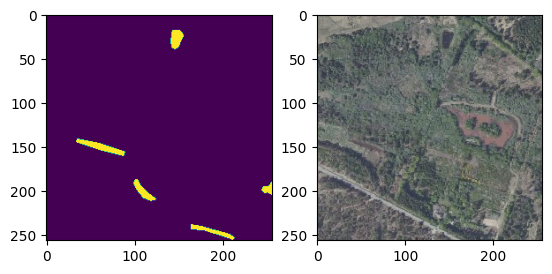

In [9]:
idx = 1 # Pick an image and mask to plot
fig, axs = plt.subplots(1,2)
axs[0].imshow(masks[idx])
axs[0].set_title('Mask')
axs[0].axis('off')

axs[1].imshow(imgs[idx].transpose(1,2,0))
axs[1].set_title('Orthographic image')
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [10]:
mask.shape, img_rgb.shape

((135000, 85000), (3, 135000, 85000))

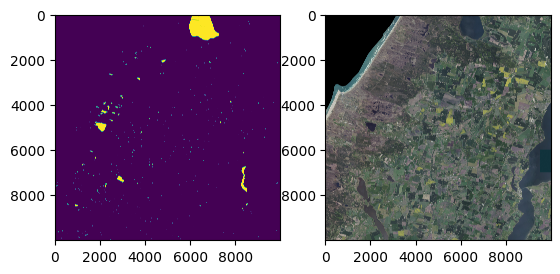

In [11]:
idx = 1
fig, axs = plt.subplots(1,2)
# Specify what location to crop the orthographic map to
x_1, x_2 = 10000, 10000  #12500, 1500
y_1, y_2 = x_1, x_2
mask_cut = mask[x_1:x_1+x_2, y_1:y_1+y_2]

axs[0].imshow(mask_cut)
axs[0].set_title('Mask')
axs[0].axis('off')

axs[1].imshow(img_rgb[:, x_1:x_1+x_2, y_1:y_1+y_2].transpose(1,2,0))
axs[1].set_title('Orthographic image')
axs[1].axis('off')
plt.tight_layout()
plt.show()

In [12]:
# Resize the mask and image to 10% the original size so it can be plotted (otherwise they're too big!)
shape_1, shape_2 = mask.shape
shape_1_small, shape_2_small = int(shape_1/10), int(shape_2/10)

mask_res = cv2.resize(mask, dsize=(shape_1_small, shape_2_small), interpolation=cv2.INTER_CUBIC)
img_res = cv2.resize(img_rgb.transpose(1,2,0), dsize=(shape_1_small, shape_2_small), interpolation=cv2.INTER_CUBIC)

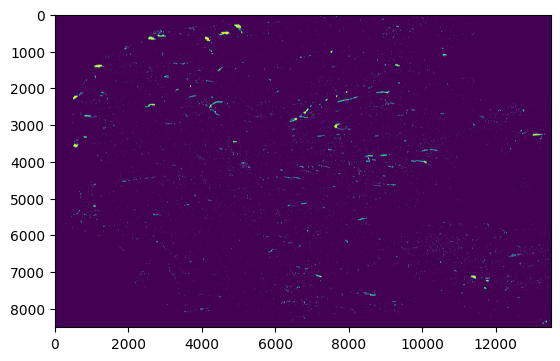

In [13]:
# Note: not all lakes are registered in paragraf 3
# In particular large lakes seem to be missing!
plt.imshow(mask_res)
plt.title('Mask of lakes in Denmark')
plt.axis('off')
plt.show()

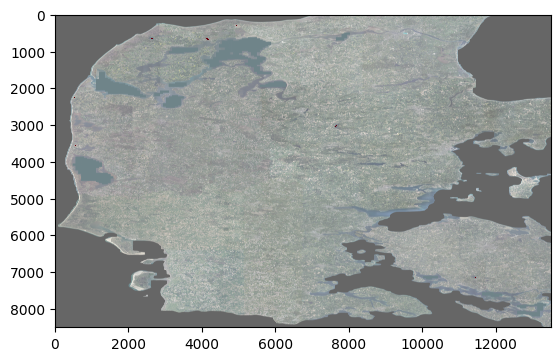

In [14]:
# Masked_where makes it so we can make the mask transparent where no water is present (i.e. mask == 0)
mask_res = np.ma.masked_where(mask_res == 0, mask_res)
plt.imshow(img_res, alpha = 0.75)
plt.imshow(mask_res, vmin = 0, vmax = 1, cmap = 'Reds')
plt.title('Orthographic map of Denmark (with water mask overlayed)')
plt.axis('off')
plt.show()